## 11.5. 小批量随机梯度下降

### 11.5.1. 向量化和缓存

In [1]:
%matplotlib inline
from d2l import mindspore as d2l
import mindspore
from mindspore import nn
import numpy as np

timer = d2l.Timer()
A = d2l.zeros((256, 256))
B = d2l.randn((256, 256))
C = d2l.randn((256, 256))

In [2]:
# 逐元素计算A=BC
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = d2l.tensor_dot(B[i, :], C[:, j], axes=1)
timer.stop()

3318.47824382782

In [3]:
# 逐列计算A=BC
timer.start()
for j in range(256):
    A[:, j] = d2l.mv(B, C[:, j])
timer.stop()

32.03338050842285

In [4]:
# 一次性计算A=BC
timer.start()
A = d2l.mm(B, C)
timer.stop()

# 乘法和加法作为单独的操作（在实践中融合）
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.001, column 0.062, full 91.153


### 11.5.2. 小批量

In [5]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = d2l.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 5.122


### 11.5.3. 读取数据集

In [2]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

### 11.5.4. 从零开始实现

In [12]:
def sgd(params, grads, states, hyperparams):
    for param, grad in zip(params, grads):
        mindspore.ops.assign_sub(param, hyperparams['lr']*grad)

In [13]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型, mindspore 张量不含梯度属性
    w = mindspore.Parameter(d2l.normal(mean=0.0, stddev=0.01, shape=(feature_dim, 1)), name='w')
    b = mindspore.Parameter(d2l.zeros((1)), name='b')
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    loss_fn = lambda x, y: loss(net(x), y).mean()
    grad_fn = mindspore.grad(loss_fn, None, [w, b])

    # 训练模型
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            [dw, db] = grad_fn(X, y)
            trainer_fn([w, b], [dw, db], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/data_iter.get_dataset_size(),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.256, 0.113 sec/epoch


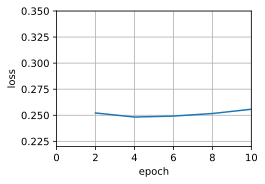

In [14]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

loss: 0.244, 3.782 sec/epoch


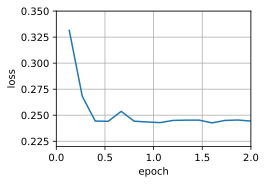

In [15]:
sgd_res = train_sgd(0.005, 1)

loss: 0.248, 0.068 sec/epoch


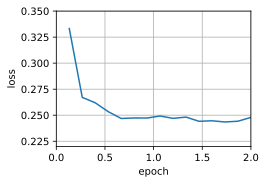

In [16]:
mini1_res = train_sgd(.4, 100)

loss: 0.245, 0.539 sec/epoch


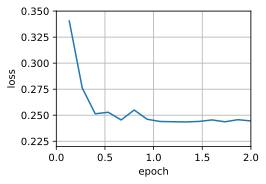

In [17]:
mini2_res = train_sgd(.05, 10)

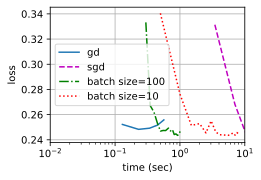

In [18]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

### 11.5.5. 简洁实现¶

In [3]:
#@save
from mindspore.common import initializer as init

def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    net = nn.SequentialCell(nn.Dense(5, 1),)
    
    def init_weights(m):
        if type(m) == nn.Dense:
            m.weight.set_data(init.initializer(init.Normal(0.01), m.weight.shape))

    net.apply(init_weights)
    optimizer = trainer_fn(net.trainable_params(), **hyperparams)

    loss = nn.MSELoss(reduction='none')
    forward_fn = lambda X, y: loss(net(X), y).mean()
    
    # Get gradient function
    grad_fn = mindspore.value_and_grad(forward_fn, None, net.trainable_params())
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            output, grads = grad_fn(X, y)
            optimizer(grads)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/data_iter.get_dataset_size(),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.242, 0.050 sec/epoch


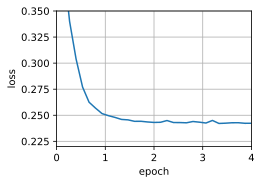

In [4]:
data_iter, _ = get_data_ch11(10)
trainer = nn.SGD
train_concise_ch11(trainer, {'learning_rate': 0.01}, data_iter)